In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import math
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
data = pd.read_csv('tesla.csv')

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2015,222.869995,223.250000,213.259995,219.309998,219.309998,4764400
1,1/5/2015,214.550003,216.500000,207.160004,210.089996,210.089996,5368500
2,1/6/2015,210.059998,214.199997,204.210007,211.279999,211.279999,6261900
3,1/7/2015,213.350006,214.779999,209.779999,210.949997,210.949997,2968400
4,1/8/2015,212.809998,213.800003,210.009995,210.619995,210.619995,3442500


In [5]:
data.shape

(1404, 7)

In [6]:
data = data.iloc[:,4:5]

In [7]:
data.head()

,Close
0,219.309998
1,210.089996
2,211.279999
3,210.949997
4,210.619995


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1404 non-null   float64
dtypes: float64(1)
memory usage: 11.1 KB


In [9]:
train_df = data.iloc[:1000,:].values

In [10]:
train_df.shape

(1000, 1)

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
train_df = scaler.fit_transform(train_df)

In [12]:
train_df.shape

(1000, 1)

In [13]:
#Preparing the data for LSTM
x_train = []
y_train = []
for i in range(60,1000):
  x_train.append(train_df[i-60:i,0])
  y_train.append(train_df[i,0])

x_train,y_train = np.array(x_train), np.array(y_train)

In [14]:
#Reshape for LSTM

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [15]:
x_train.shape

(940, 60, 1)

In [16]:
model = Sequential()

model.add(LSTM(units=60,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=80,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=1200))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer ='adam', loss='mean_squared_error')

In [17]:
#Fitting the model

hist = model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
30/30 [==============================] - 77s 3s/step - loss: 3.0657
Epoch 2/100
30/30 [==============================] - 77s 3s/step - loss: 0.0323
Epoch 3/100
30/30 [==============================] - 77s 3s/step - loss: 0.0133
Epoch 4/100
30/30 [==============================] - 76s 3s/step - loss: 0.0120
Epoch 5/100
30/30 [==============================] - 77s 3s/step - loss: 0.0116
Epoch 6/100
30/30 [==============================] - 76s 3s/step - loss: 0.0117
Epoch 7/100
30/30 [==============================] - 76s 3s/step - loss: 0.0117
Epoch 8/100
30/30 [==============================] - 77s 3s/step - loss: 0.0121
Epoch 9/100
30/30 [==============================] - 77s 3s/step - loss: 0.0107
Epoch 10/100
30/30 [==============================] - 77s 3s/step - loss: 0.0104
Epoch 11/100
30/30 [==============================] - 78s 3s/step - loss: 0.0104
Epoch 12/100
30/30 [==============================] - 77s 3s/step - loss: 0.0099
Epoch 13/100
30/30 [=================

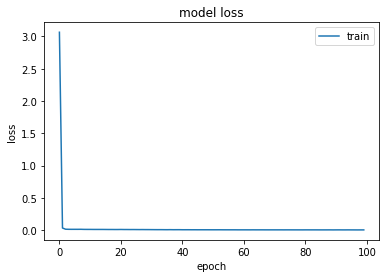

In [18]:
#Plot the training Loss

plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper right')
plt.show()

In [19]:
train_data = data.iloc[:1000,:]
test_data = data.iloc[1000:,:]
total_data = pd.concat((train_data,test_data),axis=0)

In [20]:
inputs = total_data[len(total_data)-len(test_data)-60:].values

In [21]:
inputs.shape

(464, 1)

In [22]:
inputs = inputs.reshape(-1,1)

In [23]:
inputs = scaler.transform(inputs)

In [24]:
x_test = []
for i in range(60,464):
  x_test.append(inputs[i-60:i,0])

In [25]:
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [26]:
x_test.shape

(404, 60, 1)

In [27]:
#Make Predictions

predicted_price = model.predict(x_test)
predicted_price = scaler.inverse_transform(predicted_price)

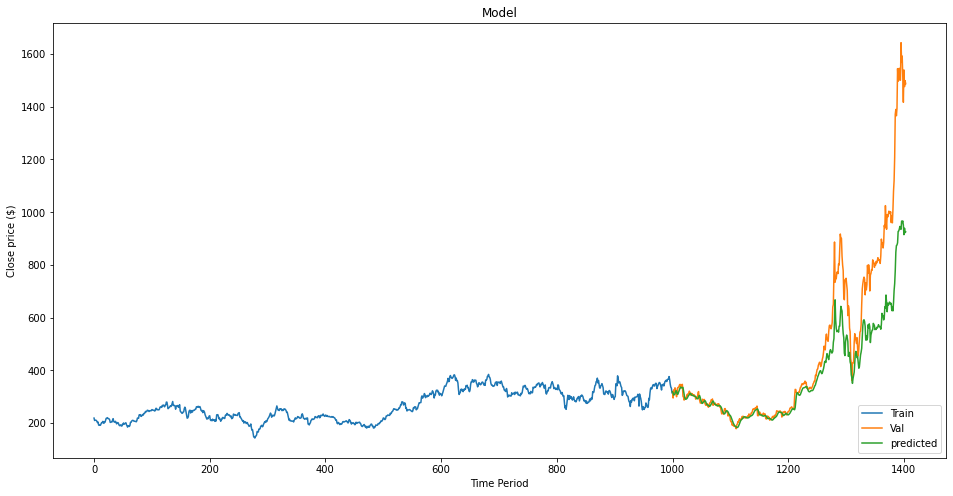

In [28]:
#Visualization

train = data[:1000]
valid = data[1000:]
valid['predicted']=predicted_price
plt.figure(figsize=(16,8))
plt.title('Model')
plt.ylabel('Close price ($)')
plt.xlabel('Time Period')
plt.plot(train['Close'])
plt.plot(valid[['Close','predicted']])
plt.legend(['Train','Val','predicted'],loc='lower right')
plt.show()

In [29]:
print(valid)

            Close   predicted
1000   319.769989  319.213348
1001   295.390015  314.549286
1002   326.089996  306.380005
1003   316.130005  308.197510
1004   333.869995  310.848938
...           ...         ...
1399  1417.000000  951.196350
1400  1539.599976  914.850769
1401  1476.489990  939.435303
1402  1499.109985  922.755310
1403  1487.489990  925.590942

[404 rows x 2 columns]
